# Réalisation des prédictions des races de chien

Modèle chargé : **Transfert Learning InceptionV3**

2 méthodes utilisées pour les prédictions : 
- Via des images aléatoire de l'API https://dog.ceo/dog-api/
- Via des images en local

In [1]:
import requests
import os
import time

import numpy as np
from PIL import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model
from tensorflow.keras.applications.inception_v3 import preprocess_input

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Chargement du modèle
Rappel des metrics : 
- accuracy : 0.86
- loss : 0.42

In [3]:
%%time
model = load_model('model_dog_TL_inceptionv3.h5')

CPU times: user 3.92 s, sys: 374 ms, total: 4.3 s
Wall time: 5.72 s


In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 120)               245880    
Total params: 22,048,664
Trainable params: 245,880
Non-trainable params: 21,802,784
_________________________________________________________________


### Chargement du mapping des races du modèle

In [5]:
#Todo v2: récupérer les labels depuis un csv généré par le notebook du modèle
label_maps = {
  0: 'n02085620-Chihuahua',
  1: 'n02085782-Japanese_spaniel',
  2: 'n02085936-Maltese_dog',
  3: 'n02086079-Pekinese',
  4: 'n02086240-Shih-Tzu',
  5: 'n02086646-Blenheim_spaniel',
  6: 'n02086910-papillon',
  7: 'n02087046-toy_terrier',
  8: 'n02087394-Rhodesian_ridgeback',
  9: 'n02088094-Afghan_hound',
  10: 'n02088238-basset',
  11: 'n02088364-beagle',
  12: 'n02088466-bloodhound',
  13: 'n02088632-bluetick',
  14: 'n02089078-black-and-tan_coonhound',
  15: 'n02089867-Walker_hound',
  16: 'n02089973-English_foxhound',
  17: 'n02090379-redbone',
  18: 'n02090622-borzoi',
  19: 'n02090721-Irish_wolfhound',
  20: 'n02091032-Italian_greyhound',
  21: 'n02091134-whippet',
  22: 'n02091244-Ibizan_hound',
  23: 'n02091467-Norwegian_elkhound',
  24: 'n02091635-otterhound',
  25: 'n02091831-Saluki',
  26: 'n02092002-Scottish_deerhound',
  27: 'n02092339-Weimaraner',
  28: 'n02093256-Staffordshire_bullterrier',
  29: 'n02093428-American_Staffordshire_terrier',
  30: 'n02093647-Bedlington_terrier',
  31: 'n02093754-Border_terrier',
  32: 'n02093859-Kerry_blue_terrier',
  33: 'n02093991-Irish_terrier',
  34: 'n02094114-Norfolk_terrier',
  35: 'n02094258-Norwich_terrier',
  36: 'n02094433-Yorkshire_terrier',
  37: 'n02095314-wire-haired_fox_terrier',
  38: 'n02095570-Lakeland_terrier',
  39: 'n02095889-Sealyham_terrier',
  40: 'n02096051-Airedale',
  41: 'n02096177-cairn',
  42: 'n02096294-Australian_terrier',
  43: 'n02096437-Dandie_Dinmont',
  44: 'n02096585-Boston_bull',
  45: 'n02097047-miniature_schnauzer',
  46: 'n02097130-giant_schnauzer',
  47: 'n02097209-standard_schnauzer',
  48: 'n02097298-Scotch_terrier',
  49: 'n02097474-Tibetan_terrier',
  50: 'n02097658-silky_terrier',
  51: 'n02098105-soft-coated_wheaten_terrier',
  52: 'n02098286-West_Highland_white_terrier',
  53: 'n02098413-Lhasa',
  54: 'n02099267-flat-coated_retriever',
  55: 'n02099429-curly-coated_retriever',
  56: 'n02099601-golden_retriever',
  57: 'n02099712-Labrador_retriever',
  58: 'n02099849-Chesapeake_Bay_retriever',
  59: 'n02100236-German_short-haired_pointer',
  60: 'n02100583-vizsla',
  61: 'n02100735-English_setter',
  62: 'n02100877-Irish_setter',
  63: 'n02101006-Gordon_setter',
  64: 'n02101388-Brittany_spaniel',
  65: 'n02101556-clumber',
  66: 'n02102040-English_springer',
  67: 'n02102177-Welsh_springer_spaniel',
  68: 'n02102318-cocker_spaniel',
  69: 'n02102480-Sussex_spaniel',
  70: 'n02102973-Irish_water_spaniel',
  71: 'n02104029-kuvasz',
  72: 'n02104365-schipperke',
  73: 'n02105056-groenendael',
  74: 'n02105162-malinois',
  75: 'n02105251-briard',
  76: 'n02105412-kelpie',
  77: 'n02105505-komondor',
  78: 'n02105641-Old_English_sheepdog',
  79: 'n02105855-Shetland_sheepdog',
  80: 'n02106030-collie',
  81: 'n02106166-Border_collie',
  82: 'n02106382-Bouvier_des_Flandres',
  83: 'n02106550-Rottweiler',
  84: 'n02106662-German_shepherd',
  85: 'n02107142-Doberman',
  86: 'n02107312-miniature_pinscher',
  87: 'n02107574-Greater_Swiss_Mountain_dog',
  88: 'n02107683-Bernese_mountain_dog',
  89: 'n02107908-Appenzeller',
  90: 'n02108000-EntleBucher',
  91: 'n02108089-boxer',
  92: 'n02108422-bull_mastiff',
  93: 'n02108551-Tibetan_mastiff',
  94: 'n02108915-French_bulldog',
  95: 'n02109047-Great_Dane',
  96: 'n02109525-Saint_Bernard',
  97: 'n02109961-Eskimo_dog',
  98: 'n02110063-malamute',
  99: 'n02110185-Siberian_husky',
  100: 'n02110627-affenpinscher',
  101: 'n02110806-basenji',
  102: 'n02110958-pug',
  103: 'n02111129-Leonberg',
  104: 'n02111277-Newfoundland',
  105: 'n02111500-Great_Pyrenees',
  106: 'n02111889-Samoyed',
  107: 'n02112018-Pomeranian',
  108: 'n02112137-chow',
  109: 'n02112350-keeshond',
  110: 'n02112706-Brabancon_griffon',
  111: 'n02113023-Pembroke',
  112: 'n02113186-Cardigan',
  113: 'n02113624-toy_poodle',
  114: 'n02113712-miniature_poodle',
  115: 'n02113799-standard_poodle',
  116: 'n02113978-Mexican_hairless',
  117: 'n02115641-dingo',
  118: 'n02115913-dhole',
  119: 'n02116738-African_hunting_dog'
}

### 1. Réalisation des prédictions à partir de l'api `dog.ceo`

In [6]:
def predict_by_api(n_predictions=1):

  for i in range(n_predictions):

    # Appel API pour obtenir aléatoirement une image de chien
    response = requests.get("https://dog.ceo/api/breeds/image/random")
    url = response.json()['message']
    image = url.split("/")[-1]
    breed = url.split("/")[-2]

    # Téléchargement de l'image
    os.system("curl -s "+ url +" -o "+image)

    # Lecture
    img = Image.open(image)

    #. Affichage de l'image avec plt
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Resize de l'image
    img = img.convert('RGB')
    img = img.resize((224, 224))
    img.save(image)

    # Affichage de la race à prédire
    print("True : "+breed)

    # Preprocessing
    img = mpimg.imread(image)
    img = preprocess_input(img)

    #Appel au model et prediction
    start_time_pred = time.time()
    probas = model.predict(np.expand_dims(img, axis=0))
    exec_time_pred = round((time.time() - start_time_pred), 2)

    # Formatage et affichage des 3 meilleures prédictions
    print("\nPredictions : ")
    for idx in probas.argsort()[0][::-1][:3]:
        print("{:.2f}%".format(probas[0][idx]*100), "\t", label_maps[idx].split("-")[-1])

    # Nettoyage
    os.remove(image)

    print('\nDurée du model.predict() : '+str(exec_time_pred)+'s')
    print('\n--------------------------------------------------\n')

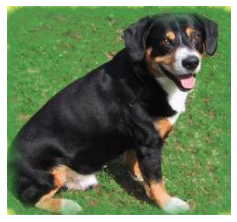

True : entlebucher

Predictions : 
97.12% 	 EntleBucher
1.80% 	 Appenzeller
0.64% 	 Greater_Swiss_Mountain_dog

Durée du model.predict() : 0.18s

--------------------------------------------------



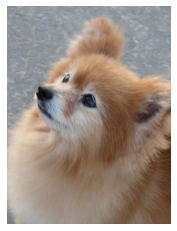

True : pomeranian

Predictions : 
99.35% 	 Pomeranian
0.21% 	 keeshond
0.17% 	 chow

Durée du model.predict() : 0.18s

--------------------------------------------------



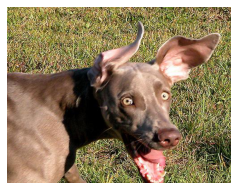

True : weimaraner

Predictions : 
95.98% 	 Weimaraner
1.65% 	 whippet
1.14% 	 Great_Dane

Durée du model.predict() : 0.18s

--------------------------------------------------



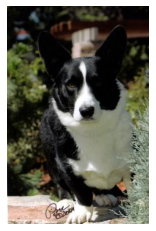

True : corgi-cardigan

Predictions : 
98.22% 	 Cardigan
0.69% 	 kelpie
0.52% 	 Border_collie

Durée du model.predict() : 0.18s

--------------------------------------------------



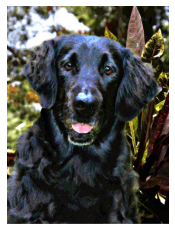

True : retriever-flatcoated

Predictions : 
90.09% 	 coated_retriever
2.02% 	 golden_retriever
1.78% 	 Irish_setter

Durée du model.predict() : 0.18s

--------------------------------------------------



In [ ]:
# Prédictions des races de 5 chiens choisis au hasard via l'api https://dog.ceo/dog-api/
predict_by_api(5)

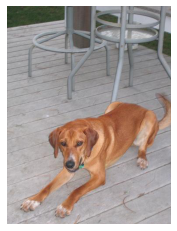

True : redbone

Predictions : 
82.80% 	 redbone
13.44% 	 Rhodesian_ridgeback
2.27% 	 golden_retriever

Durée du model.predict() : 0.21s

--------------------------------------------------



In [12]:
predict_by_api(1)

### 2. Réalisation des prédictions à partir d'image en local

In [7]:
def predict_by_filename(filename):
  in_file = 'in/'+filename
  processed_file = 'in/processed_'+filename

  # Lecture
  img = Image.open(in_file)

  #. Affichage de l'image avec plt
  plt.figure(figsize=(4, 4))
  plt.imshow(img)
  plt.axis('off')
  plt.show()

  # Resize de l'image
  img = img.convert('RGB')
  img = img.resize((224, 224))
  img.save(processed_file)

  # Preprocessing
  img = mpimg.imread(processed_file)
  img = preprocess_input(img)

  # Affichage du nom du fichier
  print("Image : "+filename)

  #Appel au model et prediction
  start_time_pred = time.time()
  probas = model.predict(np.expand_dims(img, axis=0))
  exec_time_pred = round((time.time() - start_time_pred), 2)

  # Formatage et affichage des 3 meilleures prédictions
  print("\nPredictions : ")
  for idx in probas.argsort()[0][::-1][:3]:
      print("{:.2f}%".format(probas[0][idx]*100), "\t", label_maps[idx].split("-")[-1])

  # Nettoyage
  os.remove(processed_file)

  print('\nDurée du model.predict() : '+str(exec_time_pred)+'s')
  print('\n--------------------------------------------------\n')

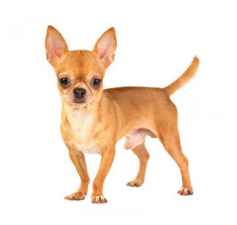

Image : chihuahua.jpeg

Predictions : 
97.19% 	 Chihuahua
0.98% 	 miniature_pinscher
0.66% 	 Brabancon_griffon

Durée du model.predict() : 1.9s

--------------------------------------------------



Image : labrador.jpg

Predictions : 
95.63% 	 Labrador_retriever
4.03% 	 golden_retriever
0.04% 	 coated_retriever

Durée du model.predict() : 0.19s

--------------------------------------------------



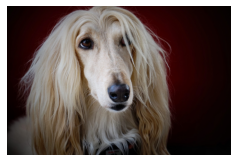

Image : lévrier_afghan.jpg

Predictions : 
78.38% 	 Afghan_hound
21.35% 	 Saluki
0.01% 	 Lhasa

Durée du model.predict() : 0.17s

--------------------------------------------------



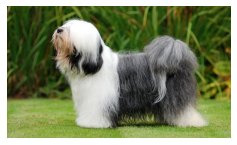

Image : terrier_tibétain.jpg

Predictions : 
97.78% 	 Tibetan_terrier
1.29% 	 Lhasa
0.44% 	 Old_English_sheepdog

Durée du model.predict() : 0.44s

--------------------------------------------------



Image : bouledogue-francais.jpeg

Predictions : 
97.94% 	 French_bulldog
1.20% 	 boxer
0.53% 	 Boston_bull

Durée du model.predict() : 0.21s

--------------------------------------------------



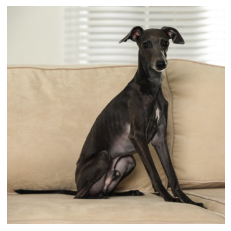

Image : lévrier_italien.jpeg

Predictions : 
44.15% 	 Italian_greyhound
27.25% 	 whippet
25.80% 	 Mexican_hairless

Durée du model.predict() : 0.2s

--------------------------------------------------



In [8]:
# Prédictions des images contenues dans le dossier in/
for file in os.listdir('in'):
  if not file.startswith('.'):
    predict_by_filename(file)